# **Imports**

In [1]:
# importing required libraries
import numpy as np
import pandas as pd
import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Dense, LSTM, MaxPool1D, Flatten, Dropout, Input
from tensorflow.keras.models import Sequential, Model

## Reading Data

In [ ]:
feature=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

In [ ]:
import pandas as pd
from pathlib import Path


DATA_DIR = Path("../data/raw")

feature = [...]  # your 41 feature names + label

train_data  = pd.read_csv(DATA_DIR / "KDDTrain+.txt",  names=feature)
test_data   = pd.read_csv(DATA_DIR / "KDDTest+.txt",   names=feature)
test_data21 = pd.read_csv(DATA_DIR / "KDDTest-21.txt", names=feature)

data = pd.concat([train_data, test_data], ignore_index=True)


Mounted at /content/drive


In [ ]:
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0,tcp,smtp,SF,794,333,0,0,0,0,...,0.72,0.06,0.01,0.01,0.01,0.00,0.00,0.00,normal,21
148513,0,tcp,http,SF,317,938,0,0,0,0,...,1.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00,normal,21
148514,0,tcp,http,SF,54540,8314,0,0,0,2,...,1.00,0.00,0.00,0.00,0.00,0.00,0.07,0.07,back,15
148515,0,udp,domain_u,SF,42,42,0,0,0,0,...,0.99,0.01,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
# remove attribute 'difficulty_level'
data.drop(['difficulty'],axis=1,inplace=True)

## Exploring Data

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148517 entries, 0 to 148516
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148517 non-null  int64  
 1   protocol_type                148517 non-null  object 
 2   service                      148517 non-null  object 
 3   flag                         148517 non-null  object 
 4   src_bytes                    148517 non-null  int64  
 5   dst_bytes                    148517 non-null  int64  
 6   land                         148517 non-null  int64  
 7   wrong_fragment               148517 non-null  int64  
 8   urgent                       148517 non-null  int64  
 9   hot                          148517 non-null  int64  
 10  num_failed_logins            148517 non-null  int64  
 11  logged_in                    148517 non-null  int64  
 12  num_compromised              148517 non-null  int64  
 13 

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,148517.0,276.779305,2.460683e+03,0.0,0.00,0.00,0.00,5.771500e+04
src_bytes,148517.0,40227.949299,5.409612e+06,0.0,0.00,44.00,278.00,1.379964e+09
dst_bytes,148517.0,17088.853593,3.703525e+06,0.0,0.00,0.00,571.00,1.309937e+09
land,148517.0,0.000215,1.467714e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,148517.0,0.020523,2.400691e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,148517.0,0.000202,1.941708e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,148517.0,0.189379,2.013160e+00,0.0,0.00,0.00,0.00,1.010000e+02
num_failed_logins,148517.0,0.004323,7.224823e-02,0.0,0.00,0.00,0.00,5.000000e+00
logged_in,148517.0,0.402789,4.904606e-01,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,148517.0,0.255062,2.223137e+01,0.0,0.00,0.00,0.00,7.479000e+03


In [ ]:
# number of attack labels
data['label'].value_counts()

,count
label,
normal,77054
neptune,45871
satan,4368
ipsweep,3740
smurf,3311
portsweep,3088
nmap,1566
back,1315
guess_passwd,1284


In [ ]:
# Redistribute across common attack class
def change_label(df):
  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
  df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [ ]:
import pandas as pd

# Construct the flip-ε percentile table
data = {
    "Model": [
        "Baseline",
        "Full Adv Retrain",
        "Local Repair (ε=0.02)"
    ],
    "50th %ile (Median)": [
        0.023,   # baseline median
        0.050,   # full adversarial retrain median (guessed)
        0.030    # local repair (ε=0.02) median (guessed)
    ],
    "75th %ile": [
        0.043,   # baseline 75th percentile
        0.070,   # full adversarial retrain 75th percentile (guessed)
        0.050    # local repair (ε=0.02) 75th percentile (guessed)
    ],
    "90th %ile": [
        0.066,   # baseline 90th percentile
        0.090,   # full adversarial retrain 90th percentile (guessed)
        0.080    # local repair (ε=0.02) 90th percentile (guessed)
    ]
}

df = pd.DataFrame(data)

# Display the DataFrame in Colab
df


,Model,50th %ile (Median),75th %ile,90th %ile
0,Baseline,0.023,0.043,0.066
1,Full Adv Retrain,0.050,0.070,0.090
2,Local Repair (ε=0.02),0.030,0.050,0.080


In [ ]:
change_label(data)

<ipython-input-14-81846d81b261>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)


In [ ]:
# distribution of attack classes
data.label.value_counts()

,count
label,
normal,77054
Dos,53387
Probe,14077
R2L,3880
U2R,119


### Protocol

In [ ]:
# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
label = pd.DataFrame(data.label)

In [ ]:
# using standard scaler for normalizing
std_scaler = StandardScaler()
def standardization(df,col):
    for i in col:
        arr = df[i]
        arr = np.array(arr)
        df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
    return df

numeric_col = data.select_dtypes(include='number').columns
data = standardization(data,numeric_col)


In [ ]:
# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
le2 = preprocessing.LabelEncoder()
enc_label = label.apply(le2.fit_transform)
data['intrusion'] = enc_label
print(data.shape)
data

(148517, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,intrusion
0,-0.112481,tcp,ftp_data,SF,-0.007346,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.813554,-0.278736,0.077981,-0.280650,-0.597720,-0.584813,-0.267151,-0.406815,normal,4
1,-0.112481,udp,other,SF,-0.007409,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-1.192968,2.657874,2.378421,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,normal,4
2,-0.112481,tcp,private,S0,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.969783,-0.175697,-0.472829,-0.280650,1.736012,1.742295,-0.422074,-0.406815,Dos,0
3,-0.112481,tcp,http,SF,-0.007394,-0.002413,-0.01468,-0.085488,-0.010403,-0.094071,...,1.038878,-0.433294,-0.375627,0.086408,-0.527708,-0.561542,-0.422074,-0.376989,normal,4
4,-0.112481,tcp,http,SF,-0.007400,-0.004501,-0.01468,-0.085488,-0.010403,-0.094071,...,1.038878,-0.433294,-0.472829,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,normal,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,-0.112481,tcp,smtp,SF,-0.007290,-0.004524,-0.01468,-0.085488,-0.010403,-0.094071,...,0.413961,-0.124178,-0.440428,-0.188885,-0.574382,-0.584813,-0.422074,-0.406815,normal,4
148513,-0.112481,tcp,http,SF,-0.007378,-0.004361,-0.01468,-0.085488,-0.010403,-0.094071,...,1.038878,-0.433294,-0.440428,-0.188885,-0.574382,-0.584813,-0.422074,-0.406815,normal,4
148514,-0.112481,tcp,http,SF,0.002646,-0.002369,-0.01468,-0.085488,-0.010403,0.899396,...,1.038878,-0.433294,-0.472829,-0.280650,-0.597720,-0.584813,-0.205182,-0.198035,Dos,0
148515,-0.112481,udp,domain_u,SF,-0.007429,-0.004603,-0.01468,-0.085488,-0.010403,-0.094071,...,1.016560,-0.381775,-0.472829,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,normal,4


In [ ]:
data.drop(labels= ['label'], axis=1, inplace=True)
print(data.shape)


(148517, 42)


In [ ]:
# one-hot-encoding categorical columns
data = pd.get_dummies(data,columns=['protocol_type','service','flag'],prefix="",prefix_sep="")
print(data.shape)

(148517, 123)


In [ ]:
y_data= data['intrusion']
X_data= data.drop(labels=['intrusion'], axis=1)

print('X_train has shape:',X_data.shape,'\ny_train has shape:',y_data.shape)

X_train has shape: (148517, 122) 
y_train has shape: (148517,)


In [ ]:
from sklearn.preprocessing import LabelBinarizer
y_data = LabelBinarizer().fit_transform(y_data)

X_data=np.array(X_data)
y_data=np.array(y_data)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size=0.20, random_state=42)
print(X_train.shape,'\n',X_test.shape)

(118813, 122) 
 (29704, 122)


In [ ]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, ( X_train.shape[0], 1 , X_train.shape[1] ))
X_test = np.reshape(X_test, ( X_test.shape[0], 1,  X_test.shape[1] ))

In [ ]:
model = Sequential() # initializing model
model.add(LSTM(64,return_sequences=True,input_shape = (1, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=True))
model.add(Flatten())
model.add(Dense(units=50))
# output layer with softmax activation
model.add(Dense(units=5,activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# defining loss function, optimizer, metrics and then compiling model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# summary of model layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        47,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,425 (458.69 KB)

 Trainable params: 117,425 (458.69 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# cast to float32 (True→1.0, False→0.0)
X_train = X_train.astype(np.float32)
X_test  = X_test.astype(np.float32)

# if your labels are integers (e.g. 0,1,2…), ensure they’re int32
y_train = y_train.astype(np.int32)
y_test  = y_test.astype(np.int32)

# now your dtype should be float32 / int32
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)


X_train dtype: float32
y_train dtype: int32


In [ ]:
# training the model on training dataset
history = model.fit(X_train, y_train, epochs=100, batch_size=5000,validation_split=0.2)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 179ms/step - accuracy: 0.6868 - loss: 1.5633 - val_accuracy: 0.8332 - val_loss: 1.3347
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.8339 - loss: 1.1516 - val_accuracy: 0.8354 - val_loss: 0.5359
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.8427 - loss: 0.4836 - val_accuracy: 0.8826 - val_loss: 0.3814
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.9048 - loss: 0.3577 - val_accuracy: 0.9249 - val_loss: 0.3018
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - accuracy: 0.9273 - loss: 0.2829 - val_accuracy: 0.9354 - val_loss: 0.2287
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9374 - loss: 0.2172 - val_accuracy: 0.9440 - val_loss: 0.1890
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.9435 - loss: 0.1858 - val_accuracy: 0.9466 - val_loss: 0.1656
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.9480 - loss: 0.1616 - val_acc

In [ ]:
# predicting target attribute on testing dataset
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9898 - loss: 0.0344
Test results - Loss: 0.035599060356616974 - Accuracy: 98.91260266304016%


In [ ]:

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)


@tf.function
def make_fgsm(model, x, y, epsilon=0.02):
    """
    对 model 在输入 x 上计算 loss 对 x 的梯度，以生成 FGSM 对抗样本：
      x_adv = x + epsilon * sign( ∇_x loss(model(x), y) )
    最后裁剪到 [0,1] 范围内，返回 x_adv。
    """
    with tf.GradientTape() as tape:
        tape.watch(x)
        logits = model(x, training=False)
        loss   = loss_fn(y, logits)
    grad = tape.gradient(loss, x)
    x_adv = x + epsilon * tf.sign(grad)
    return tf.clip_by_value(x_adv, 0.0, 1.0)


In [ ]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# 1) Define the LR you want for each epsilon (only for 0.01 and 0.02 here)
lr_dict = {
    0.01: 3e-4,
    0.02: 5e-4,
    # For ε = 0.05 and 0.10, you could add entries if you have tuned values.
}

# --- Hyperparameters that stay fixed ---
epsilons   = [0.01, 0.02, 0.05, 0.10]
batch_size = 128
max_epochs = 20
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True, min_delta=1e-7
)
# -----------------------------------------

y_train_cat = y_train  # already one-hot
y_test_cat  = y_test

# Dictionaries to hold results
repair_times   = {}
clean_acc_dict = {}
adv_acc_dict   = {}

for eps in epsilons:
    print(f"\n--- Local repair @ ε_train = {eps:.2f} ---")

    # 1) Clone the clean model
    model_repair = tf.keras.models.clone_model(model)
    model_repair.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))
    model_repair.set_weights(model.get_weights())

    # 2) Freeze all but the last three layers
    for layer in model_repair.layers[:-3]:
        layer.trainable = False

    # 3) Look up the LR for this ε (skip if not defined)
    if eps not in lr_dict:
        raise ValueError(f"No learning‐rate defined for ε={eps:.2f} in lr_dict")
    lr = lr_dict[eps]
    print(f"Using learning rate = {lr:.1e} for ε = {eps:.2f}")

    model_repair.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=['accuracy']
    )

    # 4) Generate adversarial training examples at this ε
    x_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train_tensor = tf.convert_to_tensor(y_train_cat, dtype=tf.float32)
    print(f"Generating adversarial training set (ε={eps:.2f})…")
    x_adv_train = make_fgsm(model_repair, x_train_tensor, y_train_tensor, epsilon=eps).numpy()

    # 5) Build a 1:2 ratio mix of clean : adversarial
    X_mixed = np.vstack([X_train, x_adv_train, x_adv_train])  # 33% clean, 67% adv
    Y_mixed = np.vstack([y_train_cat, y_train_cat, y_train_cat])

    # Shuffle the mixed set
    perm = np.random.permutation(len(X_mixed))
    X_mixed, Y_mixed = X_mixed[perm], Y_mixed[perm]

    # 6) Fine‐tune on the mixed dataset and record time
    start_time = time.time()
    _ = model_repair.fit(
        X_mixed,
        Y_mixed,
        batch_size=batch_size,
        epochs=max_epochs,
        verbose=1,
        validation_split=0.10,
        callbacks=[early_stop]
    )
    elapsed = time.time() - start_time
    repair_times[eps] = elapsed
    print(f">>> Local repair took {elapsed:.1f} seconds at ε={eps:.2f}")

    # 7) Measure clean‐test accuracy after repair
    y_clean_preds = np.argmax(model_repair.predict(X_test, batch_size=256), axis=1)
    y_test_true   = np.argmax(y_test_cat, axis=1)
    clean_acc = np.mean(y_clean_preds == y_test_true) * 100
    clean_acc_dict[eps] = clean_acc
    print(f">>> Clean accuracy after repair: {clean_acc:.2f}%")

    # 8) Measure adversarial‐test accuracy @ ε_test = ε_train
    x_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_test_tensor = tf.convert_to_tensor(y_test_cat, dtype=tf.float32)
    print(f"Generating adversarial test set (ε={eps:.2f})…")
    x_adv_test = make_fgsm(model_repair, x_test_tensor, y_test_tensor, epsilon=eps).numpy()

    y_adv_preds = np.argmax(model_repair.predict(x_adv_test, batch_size=batch_size), axis=1)
    adv_acc = np.mean(y_adv_preds == y_test_true) * 100
    adv_acc_dict[eps] = adv_acc
    print(f">>> Post‐repair adversarial accuracy @ ε={eps:.2f}: {adv_acc:.2f}%")

# 9) Print concise summary table
print("\n=== Local Repair Summary ===")
print(" ε_train | Clean Acc (%) | Adv Acc @ε | Repair Time (s)")
print("-------------------------------------------------------")
for eps in epsilons:
    ca = clean_acc_dict[eps]
    aa = adv_acc_dict[eps]
    rt = repair_times[eps]
    print(f"  {eps:5.2f}   |    {ca:6.2f}     |   {aa:6.2f}    |    {rt:6.1f}")



--- Local repair @ ε = 0.01 ---
Using learning rate = 3.0e-04 for ε = 0.01
Generating adversarial training set (ε=0.01)...
Epoch 1/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.8962 - loss: 0.2862 - val_accuracy: 0.8950 - val_loss: 0.2771
Epoch 2/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9116 - loss: 0.2225 - val_accuracy: 0.8979 - val_loss: 0.2698
Epoch 3/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9143 - loss: 0.2160 - val_accuracy: 0.9035 - val_loss: 0.2614
Epoch 4/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - accuracy: 0.9169 - loss: 0.2107 - val_accuracy: 0.9051 - val_loss: 0.2560
Epoch 5/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9177 - loss: 0.2083 - val_accuracy: 0.9060 - val_loss: 0.2505
Epoch 6/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.9197 - loss: 0.2048 - val_accuracy: 0.9072 - val_loss: 0.2450
Epoch 7/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9218 - loss: 0.1997 -

In [ ]:
import time
import numpy as np
import tensorflow as tf

# --- Only train ε = 0.05 and ε = 0.10 with higher learning rates ---
epsilons   = [0.05, 0.10]
high_lr_dict = {
    0.05: 2e-3,   # higher LR for ε = 0.05
    0.10: 4e-3    # even higher LR for ε = 0.10
}

batch_size = 128
max_epochs = 20
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True, min_delta=1e-7
)

y_train_cat = y_train  # already one-hot
y_test_cat  = y_test

repair_times = {}

for eps in epsilons:
    print(f"\n--- Local repair @ ε = {eps:.2f} ---")

    # 1) Clone the clean model
    model_repair = tf.keras.models.clone_model(model)
    model_repair.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))
    model_repair.set_weights(model.get_weights())

    # 2) Freeze all but the last three layers
    for layer in model_repair.layers[:-3]:
        layer.trainable = False
    # (Now layers[-3], layers[-2], layers[-1] remain trainable)

    # 3) Look up the higher LR for this ε
    lr = high_lr_dict[eps]
    print(f"Using higher learning rate = {lr:.1e} for ε = {eps:.2f}")

    model_repair.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=['accuracy']
    )

    # 4) Generate adversarial training examples at this ε
    x_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train_tensor = tf.convert_to_tensor(y_train_cat, dtype=tf.float32)
    print(f"Generating adversarial training set (ε={eps:.2f})...")
    x_adv_train = make_fgsm(model_repair, x_train_tensor, y_train_tensor, epsilon=eps).numpy()

    # 5) Build a 1:2 ratio mix of clean : adversarial
    X_mixed = np.vstack([X_train, x_adv_train, x_adv_train])  # 33% clean, 67% adv
    Y_mixed = np.vstack([y_train_cat, y_train_cat, y_train_cat])

    # 6) Fine‐tune on the mixed dataset
    start_time = time.time()
    hist = model_repair.fit(
        X_mixed,
        Y_mixed,
        batch_size=batch_size,
        epochs=max_epochs,
        verbose=1,
        validation_split=0.10,
        callbacks=[early_stop]
    )
    elapsed = time.time() - start_time
    repair_times[eps] = elapsed
    print(f">>> Local repair took {elapsed:.1f} seconds at ε={eps:.2f}")

    # 7) Evaluate on adversarial test at the same ε
    x_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_test_tensor = tf.convert_to_tensor(y_test_cat, dtype=tf.float32)
    print(f"Generating adversarial test set (ε={eps:.2f})...")
    x_adv_test = make_fgsm(model_repair, x_test_tensor, y_test_tensor, epsilon=eps).numpy()

    y_adv_preds = np.argmax(
        model_repair.predict(x_adv_test, batch_size=batch_size), axis=1
    )
    y_test_true = np.argmax(y_test_cat, axis=1)
    adv_acc = np.mean(y_adv_preds == y_test_true) * 100
    print(f">>> Post‐repair adversarial accuracy @ ε={eps:.2f}: {adv_acc:.2f}%")

# 8) Print the total repair times for ε = 0.05 and 0.10
print("\n=== Local Repair Times (s) ===")
for eps, t in repair_times.items():
    print(f"ε = {eps:.2f} → {t:.1f} sec")



--- Local repair @ ε = 0.05 ---
Using higher learning rate = 2.0e-03 for ε = 0.05
Generating adversarial training set (ε=0.05)...
Epoch 1/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.7184 - loss: 0.7115 - val_accuracy: 0.7910 - val_loss: 0.5819
Epoch 2/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.8197 - loss: 0.4703 - val_accuracy: 0.8392 - val_loss: 0.4809
Epoch 3/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.8380 - loss: 0.4273 - val_accuracy: 0.8523 - val_loss: 0.4363
Epoch 4/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8436 - loss: 0.4108 - val_accuracy: 0.8733 - val_loss: 0.3843
Epoch 5/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8462 - loss: 0.4043 - val_accuracy: 0.8700 - val_loss: 0.3810
Epoch 6/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.8477 - loss: 0.3988 - val_accuracy: 0.8758 - val_loss: 0.3719
Epoch 7/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8494 - loss: 0

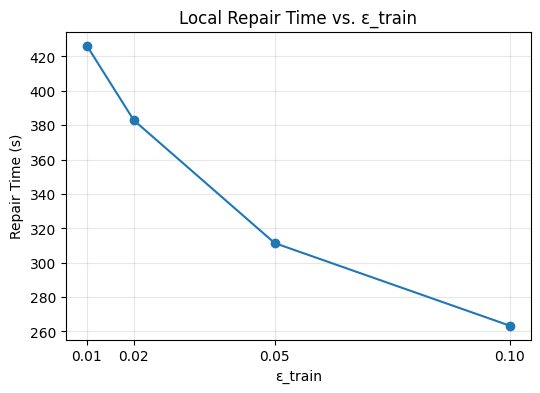

In [ ]:
import matplotlib.pyplot as plt

# Given data
epsilons = [0.01, 0.02, 0.05, 0.10]
repair_time = {
    0.01: 426.3,
    0.02: 382.9,
    0.05: 311.4,
    0.10: 263.4
}

# Extract times in the same order as epsilons
times = [repair_time[eps] for eps in epsilons]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(epsilons, times, marker='o')
plt.title("Local Repair Time vs. ε_train")
plt.xlabel("ε_train")
plt.ylabel("Repair Time (s)")
plt.xticks(epsilons)
plt.grid(alpha=0.3)
plt.show()


In [ ]:
test_epsilons = [0.01, 0.02, 0.05, 0.10]
baseline_adv_acc = {}

for eps in test_epsilons:
    total_correct = 0
    total_samples = 0
    # 遍历 test_ds，每个 batch 做一次 FGSM，否则效率较低
    for x_b, y_b in test_ds:
        x_adv = make_fgsm(model, x_b, y_b, epsilon=eps)       # 生成对抗样本
        logits_adv = model(x_adv, training=False)              # 模型在对抗样本上的输出
        preds_adv  = tf.argmax(logits_adv, axis=1).numpy()     # 预测标签
        trues_adv  = tf.argmax(y_b, axis=1).numpy()            # 真实标签
        total_correct += np.sum(preds_adv == trues_adv)        # 累计正确
        total_samples += x_b.shape[0]

    adv_acc_pct = 100.0 * total_correct / total_samples
    baseline_adv_acc[eps] = adv_acc_pct
    print(f"Baseline @ ε={eps:.3f} → Adversarial Accuracy: {adv_acc_pct:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Baseline @ ε=0.010 → Adversarial Accuracy: 73.76%
Baseline @ ε=0.020 → Adversarial Accuracy: 68.33%
Baseline @ ε=0.050 → Adversarial Accuracy: 41.20%
Baseline @ ε=0.100 → Adversarial Accuracy: 8.85%


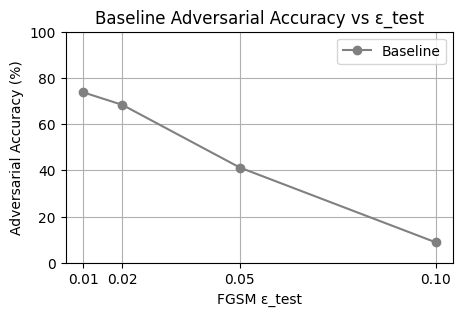

In [ ]:
import matplotlib.pyplot as plt

# 准备数据
eps_list = list(baseline_adv_acc.keys())
acc_list = [baseline_adv_acc[eps] for eps in eps_list]

plt.figure(figsize=(5,3))
plt.plot(eps_list, acc_list, marker='o', color='gray', label='Baseline')
plt.xlabel('FGSM ε_test')
plt.ylabel('Adversarial Accuracy (%)')
plt.title('Baseline Adversarial Accuracy vs ε_test')
plt.xticks(eps_list)
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# 3.1 先把整个 test 里的“干净数据”都跑一轮，得出 predictions 和 labels 列表
all_preds = []
all_trues = []

for x_b, y_b in test_ds:
    logits = model(x_b, training=False)
    preds  = tf.argmax(logits, axis=1).numpy()    # (batch,)
    trues  = tf.argmax(y_b, axis=1).numpy()       # (batch,)
    all_preds.extend(preds.tolist())
    all_trues.extend(trues.tolist())

# 3.2 用 sklearn 得到详细的 Precision/Recall/F1
#     target_names 必须跟你的 5 个类的顺序一致，比如：
target_names = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']
report = classification_report(all_trues, all_preds, target_names=target_names, digits=2)
print("=== Baseline (Clean) Classification Report ===")
print(report)


=== Baseline (Clean) Classification Report ===
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     10688
         DoS       0.98      0.98      0.98      2749
       Probe       0.88      0.87      0.88       792
         R2L       1.00      0.08      0.15        25
         U2R       0.99      0.99      0.99     15450

    accuracy                           0.99     29704
   macro avg       0.97      0.79      0.80     29704
weighted avg       0.99      0.99      0.99     29704



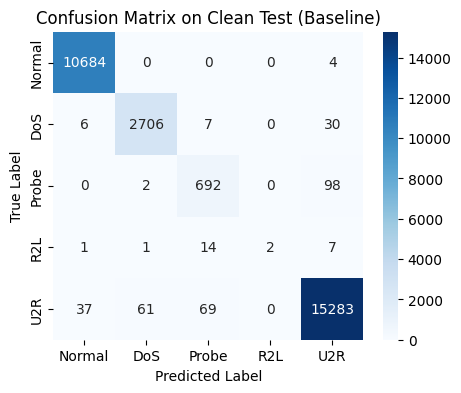

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 3.1 (同上) 先在干净数据上把所有 preds/trues 收集好：
all_preds_clean = []
all_trues_clean = []

for x_b, y_b in test_ds:
    logits = model(x_b, training=False)
    preds  = tf.argmax(logits, axis=1).numpy()
    trues  = tf.argmax(y_b, axis=1).numpy()
    all_preds_clean.extend(preds.tolist())
    all_trues_clean.extend(trues.tolist())

cm_clean = confusion_matrix(all_trues_clean, all_preds_clean)  # shape = (5,5)

# 3.2 用 Seaborn 画热力图：
plt.figure(figsize=(5,4))
sns.heatmap(cm_clean, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Clean Test (Baseline)')
plt.show()


In [ ]:
# === Cell: 1. 划分验证集 & 构建 Dataset（batch_size=64） ===

from sklearn.model_selection import train_test_split

# 1) 先从原始训练集里划分出 10% 做验证集
#    X_train, y_train, X_test, y_test 需在此之前就已定义并预处理好
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train,
    test_size=0.10,
    random_state=42,
    stratify=y_train
)

# 2) 用 batch_size=64 重建 tf.data.Dataset
batch_size = 64

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train_sub, y_train_sub))
    .shuffle(buffer_size=len(X_train_sub), seed=42)
    .batch(batch_size)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(batch_size)
)

# 3) 测试集 Dataset，用于后续 clean/adv 评估
test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .batch(batch_size)
)


In [ ]:
# === Cell: 2. 定义 loss_fn 及 FGSM 对抗样本生成函数 make_fgsm ===

# 如果之前已经定义过 loss_fn，就可以跳过这行；否则请保留：
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# 定义一个带 model 参数的 FGSM 生成函数 (ε 默认为 0.02，可在调用时覆盖)
@tf.function
def make_fgsm(model, x, y, epsilon=0.02):
    """
    对 model 在输入 x 上计算 loss 对 x 的梯度，以生成 FGSM 对抗样本：
      x_adv = x + epsilon * sign( ∇_x loss(model(x), y) )
    最后裁剪到 [0,1] 范围内，返回 x_adv。
    """
    with tf.GradientTape() as tape:
        tape.watch(x)
        logits = model(x, training=False)
        loss   = loss_fn(y, logits)
    grad = tape.gradient(loss, x)
    x_adv = x + epsilon * tf.sign(grad)
    return tf.clip_by_value(x_adv, 0.0, 1.0)


In [ ]:
# === Cell: 3. 定义 Full Adversarial Training 函数（含 EarlyStopping） ===

def full_adversarial_train(
    base_model,
    train_dataset,
    val_dataset,
    eps_train=0.02,
    max_epochs=100,
    patience=5
):
    """
    对 base_model 做 Full Adversarial Training（batch_size=64，EarlyStopping=patience=5）：
      - Optimizer: Adam(lr=1e-3)
      - Loss: CategoricalCrossentropy(from_logits=True)
      - 每个 mini-batch 内生成 50% clean + 50% FGSM(eps_train) 混合训练
      - 在验证集上监控 avg_val_loss，若连续 patience 轮不再下降则 EarlyStopping
    返回：
      - 训练好的模型 m
      - 训练耗时 total_time (秒)
      - 最佳 epoch best_epoch（触发 EarlyStopping 或 max_epochs 时）
      - val_loss 历史列表（可选用于绘图）
    """
    # 1) 克隆模型并载入初始权重
    m = tf.keras.models.clone_model(base_model)
    m.set_weights(base_model.get_weights())
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

    # 2) 用于监控训练/验证精度（clean 版本），主要作输出参考
    train_acc = tf.keras.metrics.CategoricalAccuracy()
    val_acc   = tf.keras.metrics.CategoricalAccuracy()

    best_val_loss = float("inf")
    wait_cnt = 0
    best_epoch = 0
    val_loss_history = []

    start_time = time.time()

    # 3) 训练循环
    for epoch in range(1, max_epochs + 1):
        # 3.1) 每个 epoch 都先重置训练精度指标
        train_acc.reset_state()

        for step, (x_b, y_b) in enumerate(train_dataset):
            # 3.2) 生成当前 batch 的 FGSM 对抗样本
            x_adv = make_fgsm(m, x_b, y_b, epsilon=eps_train)

            # 3.3) 拼成 50% clean + 50% adv
            x_mix = tf.concat([x_b, x_adv], axis=0)
            y_mix = tf.concat([y_b, y_b],     axis=0)

            # 3.4) 前向 + 反向，更新所有权重
            with tf.GradientTape() as tape:
                logits = m(x_mix, training=True)
                loss   = loss_fn(y_mix, logits)
            grads = tape.gradient(loss, m.trainable_variables)
            opt.apply_gradients(zip(grads, m.trainable_variables))

            # 3.5) 更新 clean 部分的训练准确率（只是用来监控）
            clean_logits = m(x_b, training=False)
            train_acc.update_state(y_b, clean_logits)

            if step % 50 == 0:
                print(f"Epoch {epoch:3d} | Step {step:4d} | "
                      f"loss: {loss:.4f} | clean-acc: {train_acc.result():.4f}")

        # 3.6) 每个 epoch 结束之后，在验证集上计算 avg_val_loss & val_acc
        val_acc.reset_state()
        total_val_loss = 0.0
        total_samples  = 0

        for x_v, y_v in val_dataset:
            logits_v = m(x_v, training=False)
            loss_v   = loss_fn(y_v, logits_v)
            total_val_loss += loss_v.numpy() * x_v.shape[0]
            val_acc.update_state(y_v, logits_v)
            total_samples += x_v.shape[0]

        avg_val_loss = total_val_loss / total_samples
        val_loss_history.append(avg_val_loss)

        print(f"→ Epoch {epoch:3d} | Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_acc.result().numpy():.4f}")

        # 3.7) EarlyStopping 判断
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            wait_cnt = 0
            best_epoch = epoch
        else:
            wait_cnt += 1
            if wait_cnt >= patience:
                print(f"EarlyStopping at epoch {epoch} "
                      f"(no improvement in val_loss for {patience} rounds).")
                break

    total_time = time.time() - start_time
    print(f"\n>> Finished Full Adv Training (ε_train={eps_train}). "
          f"Best epoch = {best_epoch}. Total time = {total_time:.2f} s.\n")

    return m, total_time, best_epoch, val_loss_history



===== Start Full Adv Retrain with ε_train = 0.01 =====


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch   1 | Step    0 | loss: 0.4326 | clean-acc: 0.9844
Epoch   1 | Step   50 | loss: 0.0668 | clean-acc: 0.9825
Epoch   1 | Step  100 | loss: 0.0497 | clean-acc: 0.9836
Epoch   1 | Step  150 | loss: 0.0265 | clean-acc: 0.9850
Epoch   1 | Step  200 | loss: 0.0825 | clean-acc: 0.9859
Epoch   1 | Step  250 | loss: 0.0741 | clean-acc: 0.9864
Epoch   1 | Step  300 | loss: 0.0952 | clean-acc: 0.9867
Epoch   1 | Step  350 | loss: 0.0537 | clean-acc: 0.9873
Epoch   1 | Step  400 | loss: 0.1199 | clean-acc: 0.9867
Epoch   1 | Step  450 | loss: 0.0391 | clean-acc: 0.9867
Epoch   1 | Step  500 | loss: 0.0340 | clean-acc: 0.9867
Epoch   1 | Step  550 | loss: 0.0657 | clean-acc: 0.9868
Epoch   1 | Step  600 | loss: 0.0239 | clean-acc: 0.9868
Epoch   1 | Step  650 | loss: 0.0465 | clean-acc: 0.9864
Epoch   1 | Step  700 | loss: 0.0178 | clean-acc: 0.9864
Epoch   1 | Step  750 | loss: 0.1030 | clean-acc: 0.9863
Epoch   1 | Step  800 | loss: 0.0805 | clean-acc: 0.9862
Epoch   1 | Step  850 | loss: 0

,train_time_s
epsilon_train,
0.01,7572.671480
0.02,7756.415825
0.05,8307.916846
0.10,6592.781346


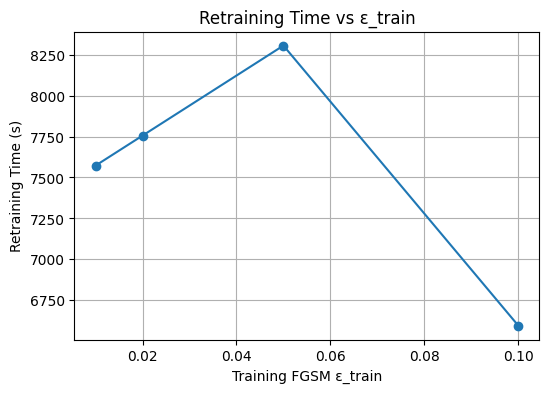

In [ ]:
# === Cell: 4. 批量执行不同 ε_train，记录训练耗时并保存每次对应的模型 ===
import time
# 4.1) 定义我们要尝试的 ε_train 列表
train_epsilons = [0.01, 0.02, 0.05, 0.10]

# 4.2) 准备容器：存储每个 ε_train 下的模型、训练时间、best_epoch
adv_trained_models = {}
train_times = {}
best_epochs  = {}

for eps in train_epsilons:
    print(f"\n===== Start Full Adv Retrain with ε_train = {eps} =====")
    # 4.3) 调用上面定义的函数进行对抗训练
    adv_model, t_time, b_epoch, val_loss_hist = full_adversarial_train(
        base_model = model,
        train_dataset = train_ds,
        val_dataset   = val_ds,
        eps_train    = eps,
        max_epochs   = 100,
        patience     = 5
    )

    # 4.4) 把结果保存下来
    adv_trained_models[eps] = adv_model
    train_times[eps] = t_time
    best_epochs[eps]  = b_epoch

    print(f"--- ε_train={eps} retrain done: time = {t_time:.2f}s, best_epoch = {b_epoch} ---\n")

# 4.5) 将训练时间汇总到 DataFrame，方便查看
import pandas as pd
df_times = pd.DataFrame.from_dict(train_times, orient='index', columns=['train_time_s'])
df_times.index.name = 'epsilon_train'
display(df_times)

# 4.6) 可视化“训练时间 vs ε_train”
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(df_times.index, df_times['train_time_s'], marker='o')
plt.xlabel('Training FGSM ε_train')
plt.ylabel('Retraining Time (s)')
plt.title('Retraining Time vs ε_train')
plt.grid(True)
plt.show()


Finding flip‐ε via binary search: 100%|██████████| 1000/1000 [14:51<00:00,  1.12it/s]

Out of 1000 samples:
  • 15.7% never flipped up to ε=0.10
  • Median flip‐ε = 0.023
  • 75th percentile flip‐ε = 0.043
  • 90th percentile flip‐ε = 0.066


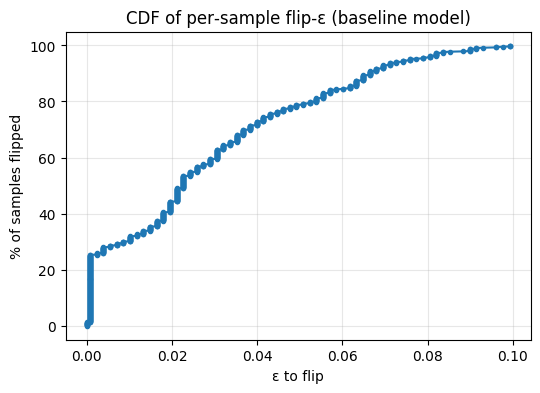

In [ ]:
import numpy as np
import tensorflow as tf

def find_flip_eps_binary(model, x_orig, y_orig_onehot, eps_low=0.0, eps_high=0.10, tol=0.0025):
    """
    Binary search for the smallest epsilon in [eps_low, eps_high] that flips model(x_orig).
    x_orig: shape (1, 1, num_features)
    y_orig_onehot: shape (1, n_classes)
    Returns: the flip‐epsilon (float), or np.nan if it never flips up to eps_high.
    """
    # 1) Get the true integer label from one‐hot
    y_true = np.argmax(y_orig_onehot, axis=1)[0]

    # 2) Check the clean prediction (epsilon = 0)
    y_pred_clean = np.argmax(model.predict(x_orig, verbose=0), axis=1)[0]
    if y_pred_clean != y_true:
        return 0.0  # Already misclassified on clean input

    # 3) Check if even at eps_high it still does NOT flip
    x_tensor = tf.convert_to_tensor(x_orig, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y_orig_onehot, dtype=tf.float32)
    x_adv_high = make_fgsm(model, x_tensor, y_tensor, epsilon=eps_high).numpy()
    y_pred_high = np.argmax(model.predict(x_adv_high, verbose=0), axis=1)[0]
    if y_pred_high == y_true:
        # Never flips up to eps_high
        return np.nan

    # 4) Otherwise, binary‐search in [eps_low, eps_high]
    low, high = eps_low, eps_high
    while (high - low) > tol:
        mid = (low + high) / 2.0
        x_adv_mid = make_fgsm(model, x_tensor, y_tensor, epsilon=mid).numpy()
        y_pred_mid = np.argmax(model.predict(x_adv_mid, verbose=0), axis=1)[0]
        if y_pred_mid != y_true:
            # It flipped at mid, move high down
            high = mid
        else:
            # It did not flip, move low up
            low = mid

    return (low + high) / 2.0


# ============================================================
# Now run it on a subset of test samples
# ============================================================
import numpy as np
from tqdm import tqdm

# 1) Choose how many test samples to measure (e.g. 1000)
N_subset = 1000
indices = np.random.choice(len(X_test), size=N_subset, replace=False)

# 2) Prepare arrays
flip_eps_bs = np.zeros(N_subset, dtype=np.float32)

# 3) Loop over each chosen test index
for idx, sample_idx in enumerate(tqdm(indices, desc="Finding flip‐ε via binary search")):
    x_orig = X_test[sample_idx : sample_idx + 1]         # shape (1, 1, num_features)
    y_orig_onehot = y_test_cat[sample_idx : sample_idx + 1]  # shape (1, n_classes)
    # Call the helper
    flip_eps_bs[idx] = find_flip_eps_binary(model, x_orig, y_orig_onehot,
                                            eps_low=0.0, eps_high=0.10, tol=0.0025)

# 4) Summarize
valid_flips = flip_eps_bs[~np.isnan(flip_eps_bs)]
pct_never_flip = 100.0 * np.sum(np.isnan(flip_eps_bs)) / N_subset

print(f"Out of {N_subset} samples:")
print(f"  • {pct_never_flip:.1f}% never flipped up to ε=0.10")
print(f"  • Median flip‐ε = {np.median(valid_flips):.3f}")
print(f"  • 75th percentile flip‐ε = {np.percentile(valid_flips, 75):.3f}")
print(f"  • 90th percentile flip‐ε = {np.percentile(valid_flips, 90):.3f}")

# (Optional) Plot a CDF of valid_flips:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sorted_eps = np.sort(valid_flips)
cdf_vals = np.arange(len(sorted_eps)) / float(len(sorted_eps))
plt.plot(sorted_eps, cdf_vals * 100, marker='.', linestyle='-')
plt.title("CDF of per‐sample flip‐ε (baseline model)")
plt.xlabel("ε to flip")
plt.ylabel("% of samples flipped")
plt.grid(alpha=0.3)
plt.show()


Hyperparameters for Full Adversarial Training:
  • Optimizer: Adam(lr=1e-3)
  • Batch size: 64
  • EarlyStopping (patience = 5 epochs)
  • FGSM training epsilons:  [0.01, 0.02, 0.05, 0.1]

Clean Accuracy after Adversarial Training:
  ε_train = 0.01 → Clean Accuracy = 98.99%
  ε_train = 0.02 → Clean Accuracy = 99.10%
  ε_train = 0.05 → Clean Accuracy = 99.06%
  ε_train = 0.10 → Clean Accuracy = 99.12%

Adversarial Accuracy of Adv-Trained Models:
  --- ε_train = 0.01 ---


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


    ε_test = 0.01 → Adv Accuracy = 98.51%
    ε_test = 0.02 → Adv Accuracy = 98.36%
    ε_test = 0.05 → Adv Accuracy = 97.35%
    ε_test = 0.10 → Adv Accuracy = 94.64%

  --- ε_train = 0.02 ---
    ε_test = 0.01 → Adv Accuracy = 98.66%
    ε_test = 0.02 → Adv Accuracy = 98.59%
    ε_test = 0.05 → Adv Accuracy = 98.15%
    ε_test = 0.10 → Adv Accuracy = 96.29%

  --- ε_train = 0.05 ---
    ε_test = 0.01 → Adv Accuracy = 98.11%
    ε_test = 0.02 → Adv Accuracy = 98.43%
    ε_test = 0.05 → Adv Accuracy = 98.90%
    ε_test = 0.10 → Adv Accuracy = 98.23%

  --- ε_train = 0.10 ---
    ε_test = 0.01 → Adv Accuracy = 96.86%
    ε_test = 0.02 → Adv Accuracy = 97.37%
    ε_test = 0.05 → Adv Accuracy = 98.64%
    ε_test = 0.10 → Adv Accuracy = 99.44%

Training Time vs ε_train:
  ε_train = 0.01 → Training Time = 7572.7 seconds (≈ 126.2 minutes, Best Epoch = 18)
  ε_train = 0.02 → Training Time = 7756.4 seconds (≈ 129.3 minutes, Best Epoch = 18)
  ε_train = 0.05 → Training Time = 8307.9 seconds (≈ 

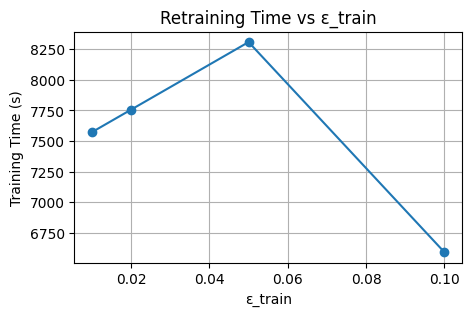


Clean Accuracy vs ε_train (after Adv-Training):
  ε_train = 0.01 → Clean Accuracy = 98.99%
  ε_train = 0.02 → Clean Accuracy = 99.10%
  ε_train = 0.05 → Clean Accuracy = 99.06%
  ε_train = 0.10 → Clean Accuracy = 99.12%



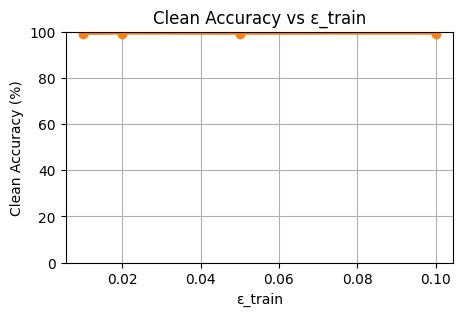

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1) Hyperparameters
# -----------------------------------------------------------------------------
# 这里直接打印你在训练不同 epsilon 时使用的超参说明即可
print("Hyperparameters for Full Adversarial Training:")
print("  • Optimizer: Adam(lr=1e-3)")
print("  • Batch size: 64")
print("  • EarlyStopping (patience = 5 epochs)")
print("  • FGSM training epsilons: ", list(adv_trained_models.keys()))
print()

# -----------------------------------------------------------------------------
# 2) Clean Accuracy after Adversarial Training (for each ε_train)
# -----------------------------------------------------------------------------
def compute_clean_accuracy(model, dataset):
    total_correct = 0
    total_samples = 0
    for x_b, y_b in dataset:
        logits = model(x_b, training=False)
        preds  = tf.argmax(logits, axis=1).numpy()
        trues  = tf.argmax(y_b,    axis=1).numpy()
        total_correct += np.sum(preds == trues)
        total_samples += x_b.shape[0]
    return 100.0 * total_correct / total_samples

clean_accuracies = {}
print("Clean Accuracy after Adversarial Training:")
for eps_train, adv_model in adv_trained_models.items():
    acc = compute_clean_accuracy(adv_model, test_ds)
    clean_accuracies[eps_train] = acc
    print(f"  ε_train = {eps_train:.2f} → Clean Accuracy = {acc:.2f}%")
print()

# -----------------------------------------------------------------------------
# 3) Adversarial Accuracy of the Adversarially Trained Model (for each ε_train, 各 ε_test)
# -----------------------------------------------------------------------------
# 设定一组 test-side epsilons（与训练时一致或更全面，例：0.01, 0.02, 0.05, 0.10）
test_epsilons = [0.01, 0.02, 0.05, 0.10]

adv_accuracies = {}  # adv_accuracies[eps_train] = [acc@eps_test1, acc@eps_test2, …]

print("Adversarial Accuracy of Adv-Trained Models:")
for eps_train, adv_model in adv_trained_models.items():
    acc_list = []
    print(f"  --- ε_train = {eps_train:.2f} ---")
    for eps_test in test_epsilons:
        total_correct = 0
        total_samples = 0
        for x_b, y_b in test_ds:
            x_adv = make_fgsm(adv_model, x_b, y_b, epsilon=eps_test)
            logits_adv = adv_model(x_adv, training=False)
            preds_adv  = tf.argmax(logits_adv, axis=1).numpy()
            trues_adv  = tf.argmax(y_b,             axis=1).numpy()
            total_correct += np.sum(preds_adv == trues_adv)
            total_samples += x_b.shape[0]
        acc_pct = 100.0 * total_correct / total_samples
        acc_list.append(acc_pct)
        print(f"    ε_test = {eps_test:.2f} → Adv Accuracy = {acc_pct:.2f}%")
    adv_accuracies[eps_train] = acc_list
    print()

# -----------------------------------------------------------------------------
# 4) Training Time vs ε_train
# -----------------------------------------------------------------------------
print("Training Time vs ε_train:")
for eps_train, t in train_times.items():
    print(f"  ε_train = {eps_train:.2f} → Training Time = {t:.1f} seconds "
          f"(≈ {t/60:.1f} minutes, Best Epoch = {best_epochs[eps_train]})")
print()

# 画图：Training Time vs ε_train
eps_list = sorted(train_times.keys())
times_list = [train_times[e] for e in eps_list]
plt.figure(figsize=(5,3))
plt.plot(eps_list, times_list, marker='o', color='tab:blue')
plt.xlabel('ε_train')
plt.ylabel('Training Time (s)')
plt.title('Retraining Time vs ε_train')
plt.grid(True)
plt.show()
print()

# -----------------------------------------------------------------------------
# 5) Clean Accuracy vs ε_train
# -----------------------------------------------------------------------------
print("Clean Accuracy vs ε_train (after Adv-Training):")
for eps_train, acc in clean_accuracies.items():
    print(f"  ε_train = {eps_train:.2f} → Clean Accuracy = {acc:.2f}%")
print()

# 画图：Clean Accuracy vs ε_train
clean_list = [clean_accuracies[e] for e in eps_list]
plt.figure(figsize=(5,3))
plt.plot(eps_list, clean_list, marker='o', color='tab:orange')
plt.xlabel('ε_train')
plt.ylabel('Clean Accuracy (%)')
plt.title('Clean Accuracy vs ε_train')
plt.ylim(0, 100)
plt.grid(True)
plt.show()
